Notebook for the article [Stop Loss, Trailing Stop, or Take Profit? 2 Million Backtests Shed Light](https://polakowo.medium.com/stop-loss-trailing-stop-or-take-profit-2-million-backtests-shed-light-dde23bda40be).

In [ ]:
from vectorbtpro import *
# whats_imported()

import ipywidgets

vbt.settings.set_theme('dark')

In [1]:
seed = 42
symbols = [
    "BTC-USD", "ETH-USD", "XRP-USD", "BCH-USD", "LTC-USD", 
    "BNB-USD", "EOS-USD", "XLM-USD", "XMR-USD", "ADA-USD"
]
start_date = vbt.utc_timestamp("2018-01-01")
end_date = vbt.utc_timestamp("2021-01-01")
time_delta = end_date - start_date
window_len = vbt.timedelta("180d")
window_cnt = 400
exit_types = ["SL", "TS", "TP", "Random", "Holding"]
step = 0.01
stops = np.arange(step, 1 + step, step)

vbt.settings.wrapping["freq"] = "d"
vbt.settings.plotting["layout"]["template"] = "vbt_dark"
vbt.settings.portfolio["init_cash"] = 100.

print(pd.Series({
    "Start date": start_date,
    "End date": end_date,
    "Time period (days)": time_delta.days,
    "Assets": len(symbols),
    "Window length": window_len,
    "Windows": window_cnt,
    "Exit types": len(exit_types),
    "Stop values": len(stops),
    "Tests per asset": window_cnt * len(stops) * len(exit_types),
    "Tests per window": len(symbols) * len(stops) * len(exit_types),
    "Tests per exit type": len(symbols) * window_cnt * len(stops),
    "Tests per stop type and value": len(symbols) * window_cnt,
    "Tests total": len(symbols) * window_cnt * len(stops) * len(exit_types)
}))

Start date                       2018-01-01 00:00:00+00:00
End date                         2021-01-01 00:00:00+00:00
Time period (days)                                    1096
Assets                                                  10
Window length                            180 days 00:00:00
Windows                                                400
Exit types                                               5
Stop values                                            100
Tests per asset                                     200000
Tests per window                                      5000
Tests per exit type                                 400000
Tests per stop type and value                         4000
Tests total                                        2000000
dtype: object


In [2]:
cols = ["Open", "Low", "High", "Close", "Volume"]
yfdata = vbt.YFData.pull(symbols, start=start_date, end=end_date)

print(yfdata.data.keys())
print(yfdata.data["BTC-USD"].shape)

  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 'BNB-USD', 'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD'])
(1096, 7)


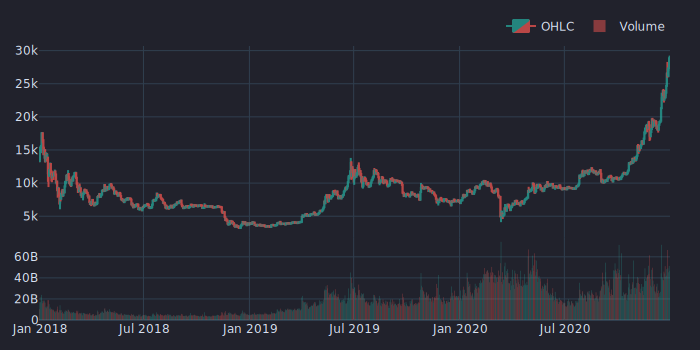

In [3]:
yfdata.plot(symbol="BTC-USD").show_svg()

In [4]:
ohlcv = yfdata.concat()

print(ohlcv.keys())
print(ohlcv["Open"].shape)

dict_keys(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])
(1096, 10)


In [5]:
splitter = vbt.Splitter.from_n_rolling(
    ohlcv["Open"].index, 
    n=window_cnt,
    length=window_len.days
)

split_ohlcv = {}
for k, v in ohlcv.items():
    split_ohlcv[k] = splitter.take(v, into="reset_stacked")
print(split_ohlcv["Open"].shape)

split_indexes = splitter.take(ohlcv["Open"].index)
print(split_indexes)
print(split_indexes[10])

(180, 4000)
split
0      DatetimeIndex(['2018-01-01 00:00:00+00:00', '2...
1      DatetimeIndex(['2018-01-03 00:00:00+00:00', '2...
2      DatetimeIndex(['2018-01-06 00:00:00+00:00', '2...
3      DatetimeIndex(['2018-01-08 00:00:00+00:00', '2...
4      DatetimeIndex(['2018-01-10 00:00:00+00:00', '2...
                             ...                        
395    DatetimeIndex(['2020-06-26 00:00:00+00:00', '2...
396    DatetimeIndex(['2020-06-28 00:00:00+00:00', '2...
397    DatetimeIndex(['2020-06-30 00:00:00+00:00', '2...
398    DatetimeIndex(['2020-07-03 00:00:00+00:00', '2...
399    DatetimeIndex(['2020-07-05 00:00:00+00:00', '2...
Length: 400, dtype: object
DatetimeIndex(['2018-01-24 00:00:00+00:00', '2018-01-25 00:00:00+00:00',
               '2018-01-26 00:00:00+00:00', '2018-01-27 00:00:00+00:00',
               '2018-01-28 00:00:00+00:00', '2018-01-29 00:00:00+00:00',
               '2018-01-30 00:00:00+00:00', '2018-01-31 00:00:00+00:00',
               '2018-02-01 00:00:00+

In [6]:
print(split_ohlcv["Open"].columns)

MultiIndex([(  0, 'BTC-USD'),
            (  0, 'ETH-USD'),
            (  0, 'XRP-USD'),
            (  0, 'BCH-USD'),
            (  0, 'LTC-USD'),
            (  0, 'BNB-USD'),
            (  0, 'EOS-USD'),
            (  0, 'XLM-USD'),
            (  0, 'XMR-USD'),
            (  0, 'ADA-USD'),
            ...
            (399, 'BTC-USD'),
            (399, 'ETH-USD'),
            (399, 'XRP-USD'),
            (399, 'BCH-USD'),
            (399, 'LTC-USD'),
            (399, 'BNB-USD'),
            (399, 'EOS-USD'),
            (399, 'XLM-USD'),
            (399, 'XMR-USD'),
            (399, 'ADA-USD')],
           names=['split', 'symbol'], length=4000)


In [7]:
entries = pd.DataFrame.vbt.signals.empty_like(split_ohlcv["Open"])
entries.iloc[0, :] = True

print(entries.shape)

(180, 4000)


In [8]:
# We use OHLCSTX instead of built-in stop-loss in Portfolio.from_signals
# because we want to analyze signals before simulation + it's easier to construct param grids
# For reality check, run the same setup using Portfolio.from_signals alone

sl_ohlcstx = vbt.OHLCSTX.run(
    entries, 
    entry_price=split_ohlcv["Close"], 
    open=split_ohlcv["Open"], 
    high=split_ohlcv["High"], 
    low=split_ohlcv["Low"], 
    close=split_ohlcv["Close"], 
    sl_stop=list(stops),
    stop_type=None
)
sl_exits = sl_ohlcstx.exits.copy()
sl_price = sl_ohlcstx.close.copy()
sl_price[sl_exits] = sl_ohlcstx.stop_price
del sl_ohlcstx

print(sl_exits.shape)

(180, 400000)


In [9]:
tsl_ohlcstx = vbt.OHLCSTX.run(
    entries, 
    entry_price=split_ohlcv["Close"], 
    open=split_ohlcv["Open"], 
    high=split_ohlcv["High"], 
    low=split_ohlcv["Low"], 
    close=split_ohlcv["Close"], 
    tsl_stop=list(stops),
    stop_type=None
)
tsl_exits = tsl_ohlcstx.exits.copy()
tsl_price = tsl_ohlcstx.close.copy()
tsl_price[tsl_exits] = tsl_ohlcstx.stop_price
del tsl_ohlcstx

print(tsl_exits.shape)

(180, 400000)


In [10]:
tp_ohlcstx = vbt.OHLCSTX.run(
    entries, 
    entry_price=split_ohlcv["Close"], 
    open=split_ohlcv["Open"], 
    high=split_ohlcv["High"], 
    low=split_ohlcv["Low"], 
    close=split_ohlcv["Close"], 
    tp_stop=list(stops),
    stop_type=None
)
tp_exits = tp_ohlcstx.exits.copy()
tp_price = tp_ohlcstx.close.copy()
tp_price[tp_exits] = tp_ohlcstx.stop_price
del tp_ohlcstx

print(tp_exits.shape)

(180, 400000)


In [11]:
def rename_stop_level(df):
    return df.vbt.rename_levels({
        "ohlcstx_sl_stop": "stop_value",
        "ohlcstx_tsl_stop": "stop_value",
        "ohlcstx_tp_stop": "stop_value"
    }, strict=False)

sl_exits = rename_stop_level(sl_exits)
tsl_exits = rename_stop_level(tsl_exits)
tp_exits = rename_stop_level(tp_exits)

sl_price = rename_stop_level(sl_price)
tsl_price = rename_stop_level(tsl_price)
tp_price = rename_stop_level(tp_price)

print(sl_exits.columns)

MultiIndex([(0.01,   0, 'BTC-USD'),
            (0.01,   0, 'ETH-USD'),
            (0.01,   0, 'XRP-USD'),
            (0.01,   0, 'BCH-USD'),
            (0.01,   0, 'LTC-USD'),
            (0.01,   0, 'BNB-USD'),
            (0.01,   0, 'EOS-USD'),
            (0.01,   0, 'XLM-USD'),
            (0.01,   0, 'XMR-USD'),
            (0.01,   0, 'ADA-USD'),
            ...
            ( 1.0, 399, 'BTC-USD'),
            ( 1.0, 399, 'ETH-USD'),
            ( 1.0, 399, 'XRP-USD'),
            ( 1.0, 399, 'BCH-USD'),
            ( 1.0, 399, 'LTC-USD'),
            ( 1.0, 399, 'BNB-USD'),
            ( 1.0, 399, 'EOS-USD'),
            ( 1.0, 399, 'XLM-USD'),
            ( 1.0, 399, 'XMR-USD'),
            ( 1.0, 399, 'ADA-USD')],
           names=['stop_value', 'split', 'symbol'], length=400000)


In [12]:
print(pd.Series({
    "SL": sl_exits.vbt.signals.total().mean(),
    "TS": tsl_exits.vbt.signals.total().mean(),
    "TP": tp_exits.vbt.signals.total().mean()
}, name="avg_num_signals"))

SL    0.428585
TS    0.587100
TP    0.520042
Name: avg_num_signals, dtype: float64


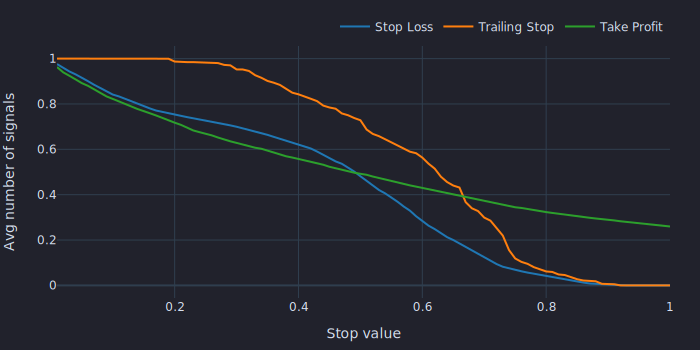

In [13]:
def groupby_stop_value(df):
    return df.vbt.signals.total().groupby("stop_value").mean()

pd.DataFrame({
    "Stop Loss": groupby_stop_value(sl_exits),
    "Trailing Stop": groupby_stop_value(tsl_exits),
    "Take Profit": groupby_stop_value(tp_exits)
}).vbt.plot(
    xaxis_title="Stop value", 
    yaxis_title="Avg number of signals"
).show_svg()

In [14]:
sl_exits.iloc[-1, :] = True
tsl_exits.iloc[-1, :] = True
tp_exits.iloc[-1, :] = True

sl_exits = sl_exits.vbt.signals.first_after(entries)
tsl_exits = tsl_exits.vbt.signals.first_after(entries)
tp_exits = tp_exits.vbt.signals.first_after(entries)

print(pd.Series({
    "SL": sl_exits.vbt.signals.total().mean(),
    "TS": tsl_exits.vbt.signals.total().mean(),
    "TP": tp_exits.vbt.signals.total().mean()
}, name="avg_num_signals"))

SL    1.0
TS    1.0
TP    1.0
Name: avg_num_signals, dtype: float64


In [15]:
hold_exits = pd.DataFrame.vbt.signals.empty_like(sl_exits)
hold_exits.iloc[-1, :] = True
hold_price = vbt.broadcast_to(split_ohlcv["Close"], sl_price)

print(hold_exits.shape)

(180, 400000)


In [16]:
rand_exits = hold_exits.vbt.shuffle(seed=seed)
rand_price = hold_price

print(rand_exits.shape)

(180, 400000)


In [17]:
exits = pd.DataFrame.vbt.concat(
    sl_exits, 
    tsl_exits, 
    tp_exits, 
    rand_exits, 
    hold_exits, 
    keys=pd.Index(exit_types, name="exit_type")
)
del sl_exits
del tsl_exits
del tp_exits
del rand_exits
del hold_exits

print(exits.shape)

(180, 2000000)


In [18]:
price = pd.DataFrame.vbt.concat(
    sl_price, 
    tsl_price, 
    tp_price, 
    rand_price, 
    hold_price, 
    keys=pd.Index(exit_types, name="exit_type")
)
del sl_price
del tsl_price
del tp_price
del rand_price
del hold_price

print(price.shape)

(180, 2000000)


In [19]:
print(exits.columns)

MultiIndex([(     'SL', 0.01,   0, 'BTC-USD'),
            (     'SL', 0.01,   0, 'ETH-USD'),
            (     'SL', 0.01,   0, 'XRP-USD'),
            (     'SL', 0.01,   0, 'BCH-USD'),
            (     'SL', 0.01,   0, 'LTC-USD'),
            (     'SL', 0.01,   0, 'BNB-USD'),
            (     'SL', 0.01,   0, 'EOS-USD'),
            (     'SL', 0.01,   0, 'XLM-USD'),
            (     'SL', 0.01,   0, 'XMR-USD'),
            (     'SL', 0.01,   0, 'ADA-USD'),
            ...
            ('Holding',  1.0, 399, 'BTC-USD'),
            ('Holding',  1.0, 399, 'ETH-USD'),
            ('Holding',  1.0, 399, 'XRP-USD'),
            ('Holding',  1.0, 399, 'BCH-USD'),
            ('Holding',  1.0, 399, 'LTC-USD'),
            ('Holding',  1.0, 399, 'BNB-USD'),
            ('Holding',  1.0, 399, 'EOS-USD'),
            ('Holding',  1.0, 399, 'XLM-USD'),
            ('Holding',  1.0, 399, 'XMR-USD'),
            ('Holding',  1.0, 399, 'ADA-USD')],
           names=['exit_type', 'stop_value'

In [20]:
print(exits.vbt.getsize())

390.0 MB


In [34]:
print(price.vbt.getsize())

2.9 GB


In [21]:
avg_distance = entries.vbt.signals.between_ranges(target=exits)\
    .duration.mean()\
    .groupby(["exit_type", "stop_value"])\
    .mean()\
    .unstack(level="exit_type")

print(avg_distance.mean())

exit_type
Holding    179.000000
Random      89.432010
SL         124.686960
TP         113.887502
TS         104.159855
dtype: float64


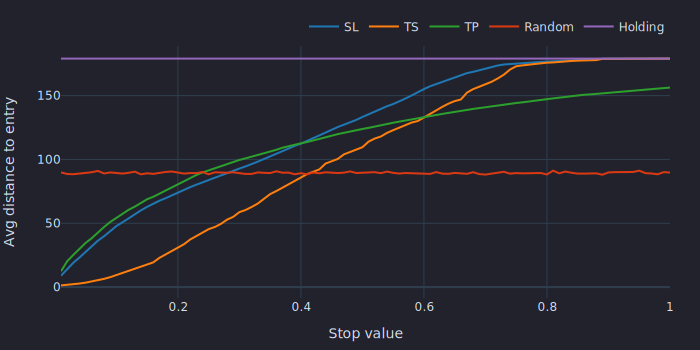

In [22]:
avg_distance[exit_types].vbt.plot(
    xaxis_title="Stop value", 
    yaxis_title="Avg distance to entry"
).show_svg()

In [24]:
%%time
pf = vbt.Portfolio.from_signals(
    split_ohlcv["Close"], 
    entries, 
    exits, 
    price=price
)

print(len(pf.orders))

3995570
CPU times: user 20.9 s, sys: 9.28 s, total: 30.2 s
Wall time: 1min 1s


In [25]:
total_return = pf.total_return
del pf

print(total_return.shape)

(2000000,)


In [23]:
import gc

total_returns = []
for i in vbt.ProgressBar(range(len(exit_types))):
    chunk_mask = exits.columns.get_level_values("exit_type") == exit_types[i]
    chunk_pf = vbt.Portfolio.from_signals(
        split_ohlcv["Close"], 
        entries, 
        exits.loc[:, chunk_mask],
        price=price.loc[:, chunk_mask]
    )
    total_returns.append(chunk_pf.total_return)
    
    del chunk_pf
    gc.collect()
    
total_return = pd.concat(total_returns)

print(total_return.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

(2000000,)


In [24]:
return_by_type = total_return.unstack(level="exit_type")[exit_types]

print(return_by_type["Holding"].describe(percentiles=[]))

count    400000.000000
mean          0.096940
std           0.833088
min          -0.909251
50%          -0.130475
max           6.565380
Name: Holding, dtype: float64


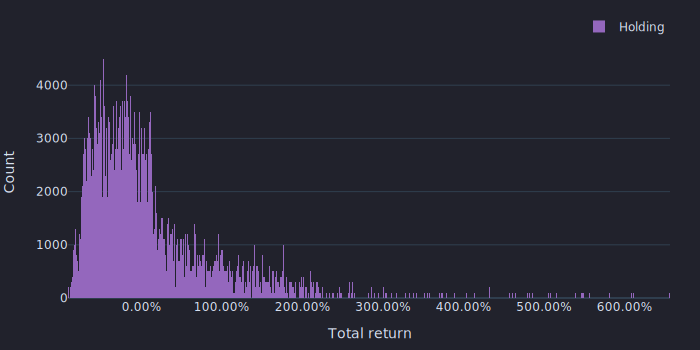

In [25]:
purple_color = vbt.settings["plotting"]["color_schema"]["purple"]
return_by_type["Holding"].vbt.histplot(
    xaxis_title="Total return",
    xaxis_tickformat=".2%",
    yaxis_title="Count",
    trace_kwargs=dict(marker_color=purple_color)
).show_svg()

In [26]:
print(pd.DataFrame({
    "Mean": return_by_type.mean(),
    "Median": return_by_type.median(),
    "Std": return_by_type.std(),
}))

               Mean    Median       Std
exit_type                              
SL         0.064957 -0.150000  0.771851
TS         0.068242 -0.084071  0.699093
TP         0.047264  0.088279  0.470234
Random     0.035533 -0.064302  0.581179
Holding    0.096940 -0.130475  0.833088


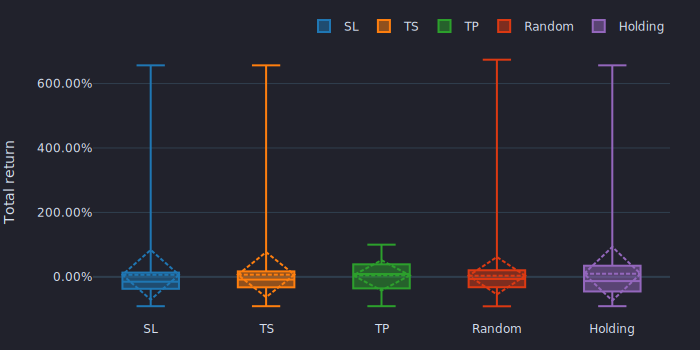

In [27]:
return_by_type.vbt.boxplot(
    trace_kwargs=dict(boxpoints=False),
    yaxis_title="Total return",
    yaxis_tickformat=".2%"
).show_svg()

In [28]:
print((return_by_type > 0).mean().rename("win_rate"))

exit_type
SL         0.311065
TS         0.375567
TP         0.598395
Random     0.417915
Holding    0.410250
Name: win_rate, dtype: float64


In [29]:
init_cash = vbt.settings.portfolio["init_cash"]

def get_expectancy(return_by_type, level_name):
    grouped = return_by_type.groupby(level_name, axis=0)
    win_rate = grouped.apply(lambda x: (x > 0).mean())
    avg_win = grouped.apply(lambda x: init_cash * x[x > 0].mean())
    avg_win = avg_win.fillna(0)
    avg_loss = grouped.apply(lambda x: init_cash * x[x < 0].mean())
    avg_loss = avg_loss.fillna(0)
    return win_rate * avg_win - (1 - win_rate) * np.abs(avg_loss)
    
expectancy_by_stop = get_expectancy(return_by_type, "stop_value")

print(expectancy_by_stop.mean())

exit_type
SL         6.495740
TS         6.824201
TP         4.726418
Random     3.388083
Holding    9.693974
dtype: float64


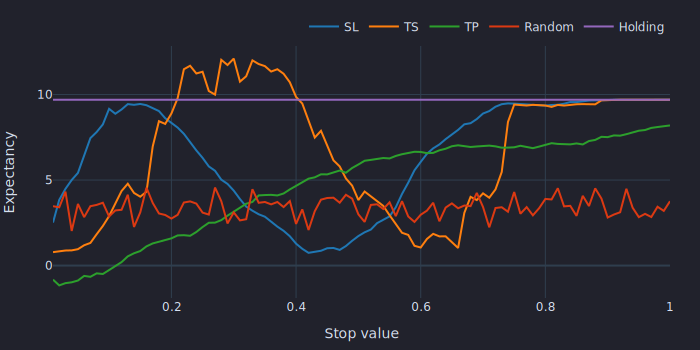

In [30]:
expectancy_by_stop.vbt.plot(
    xaxis_title="Stop value", 
    yaxis_title="Expectancy"
).show_svg()

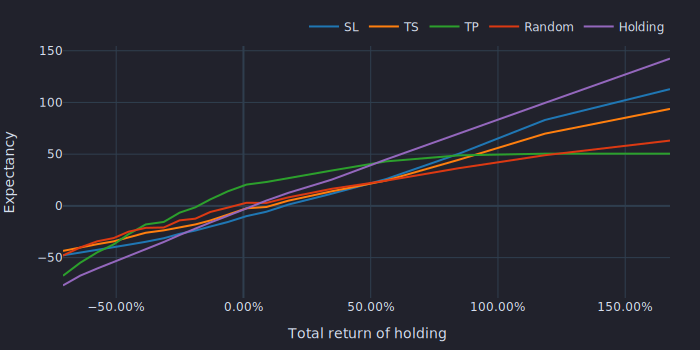

In [31]:
return_values = np.sort(return_by_type["Holding"].values)
idxs = np.ceil(np.linspace(0, len(return_values) - 1, 21)).astype(int)
bins = return_values[idxs][:-1]

def bin_return(return_by_type):
    classes = pd.cut(return_by_type["Holding"], bins=bins, right=True)
    new_level = np.array(classes.apply(lambda x: x.right))
    new_level = pd.Index(new_level, name="bin_right")
    return return_by_type.vbt.add_levels(new_level, axis=0)

binned_return_by_type = bin_return(return_by_type)

expectancy_by_bin = get_expectancy(binned_return_by_type, "bin_right")

expectancy_by_bin.vbt.plot(
    trace_kwargs=dict(mode="lines"),
    xaxis_title="Total return of holding",
    xaxis_tickformat=".2%",
    yaxis_title="Expectancy"
).show_svg()

In [32]:
range_starts = pd.DatetimeIndex(list(map(lambda x: x[0], split_indexes)))
range_ends = pd.DatetimeIndex(list(map(lambda x: x[-1], split_indexes)))

symbol_lvl = return_by_type.index.get_level_values("symbol")
split_lvl = return_by_type.index.get_level_values("split")
range_start_lvl = range_starts[split_lvl]
range_end_lvl = range_ends[split_lvl]

asset_multi_select = ipywidgets.SelectMultiple(
    options=symbols,
    value=symbols,
    rows=len(symbols),
    description="Symbols"
)
dates = np.unique(yfdata.wrapper.index)
date_range_slider = ipywidgets.SelectionRangeSlider(
    options=dates,
    index=(0, len(dates)-1),
    orientation="horizontal",
    readout=False,
    continuous_update=False
)
range_start_label = ipywidgets.Label()
range_end_label = ipywidgets.Label()
metric_dropdown = ipywidgets.Dropdown(
    options=["Mean", "Median", "Win Rate", "Expectancy"],
    value="Expectancy"
)
stop_scatter = vbt.Scatter(
    trace_names=exit_types,
    x_labels=stops, 
    xaxis_title="Stop value", 
    yaxis_title="Expectancy"
)
stop_scatter_img = ipywidgets.Image(
    format="png",
    width=stop_scatter.fig.layout.width,
    height=stop_scatter.fig.layout.height
)
bin_scatter = vbt.Scatter(
    trace_names=exit_types,
    x_labels=expectancy_by_bin.index, 
    trace_kwargs=dict(mode="lines"),
    xaxis_title="Total return of holding",
    xaxis_tickformat="%",
    yaxis_title="Expectancy"
)
bin_scatter_img = ipywidgets.Image(
    format="png",
    width=bin_scatter.fig.layout.width,
    height=bin_scatter.fig.layout.height
)

In [33]:
def update_scatter(*args, **kwargs):
    _symbols = asset_multi_select.value
    _from = date_range_slider.value[0]
    _to = date_range_slider.value[1]
    _metric_name = metric_dropdown.value
    
    range_mask = (range_start_lvl >= _from) & (range_end_lvl <= _to)
    asset_mask = symbol_lvl.isin(_symbols)
    filt = return_by_type[range_mask & asset_mask]
    
    filt_binned = bin_return(filt)
    if _metric_name == "Mean":
        filt_metric = filt.groupby("stop_value").mean()
        filt_bin_metric = filt_binned.groupby("bin_right").mean()
    elif _metric_name == "Median":
        filt_metric = filt.groupby("stop_value").median()
        filt_bin_metric = filt_binned.groupby("bin_right").median()
    elif _metric_name == "Win Rate":
        filt_metric = (filt > 0).groupby("stop_value").mean()
        filt_bin_metric = (filt_binned > 0).groupby("bin_right").mean()
    elif _metric_name == "Expectancy":
        filt_metric = get_expectancy(filt, "stop_value")
        filt_bin_metric = get_expectancy(filt_binned, "bin_right")
        
    stop_scatter.fig.update_layout(yaxis_title=_metric_name)
    stop_scatter.update(filt_metric)
    stop_scatter_img.value = stop_scatter.fig.to_image(format="png")
    
    bin_scatter.fig.update_layout(yaxis_title=_metric_name)
    bin_scatter.update(filt_bin_metric)
    bin_scatter_img.value = bin_scatter.fig.to_image(format="png")
    
    range_start_label.value = np.datetime_as_string(_from.to_datetime64(), unit="D")
    range_end_label.value = np.datetime_as_string(_to.to_datetime64(), unit="D")
    
asset_multi_select.observe(update_scatter, names="value")
date_range_slider.observe(update_scatter, names="value")
metric_dropdown.observe(update_scatter, names="value")
update_scatter()

In [34]:
dashboard = ipywidgets.VBox([
    asset_multi_select,
    ipywidgets.HBox([
        range_start_label,
        date_range_slider,
        range_end_label
    ]),
    metric_dropdown,
    stop_scatter_img,
    bin_scatter_img
])
dashboard

In [35]:
dashboard.close()